In [ ]:
Audio Feature Extraction with Librosa
The key to audio classification is to extract useful features. The librosa package in Python has a rich set of methods for extracting the features of audio samples commonly used in machine learning tasks, such as speech recognition and sound classification.

In [34]:
!pip install librosa
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=a4aaa15701cb1b8460509d25e39fee9ca9f8cb88ed857d322b6c2508f29c7fa1
  Stored in directory: /Users/sanjokdangol/Library/Caches/pip/wheels/37/01/19/e6c69a32684ab7b2e3ea4985a571d810cf055c72600e7f9f17
Successfully built python_speech_features


In [40]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
import librosa
import librosa.display

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.optimizers import Adam
from python_speech_features import mfcc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

In [13]:
df=pd.read_csv("archive/Metadata_Train.csv")
df2=pd.read_csv("archive/Metadata_Test.csv")

In [14]:
df

,FileName,Class
0,1-E1-Major 00.wav,Sound_Guitar
1,1-E1-Major 01.wav,Sound_Guitar
2,1-E1-Major 02.wav,Sound_Guitar
3,1-E1-Major 03.wav,Sound_Guitar
4,1-E1-Major 04.wav,Sound_Guitar
...,...,...
2624,strange-piano-73881.wav,Sound_Piano
2625,the-last-piano-112677.wav,Sound_Piano
2626,this-is-war-version-e-95411.wav,Sound_Piano
2627,tired-ghosts-piano-65013.wav,Sound_Piano


In [15]:
# Visualizing Tag column

print(df['Class'].value_counts())


Class
Sound_Guitar    700
Sound_Drum      700
Sound_Violin    700
Sound_Piano     529
Name: count, dtype: int64


In [24]:
# Assuming df is your DataFrame and 'FileName' is the column name with the audio file names
path = 'archive/Train_submission/Train_submission/'

# Use a list comprehension to load the audio data and sample rate
audio_data = [librosa.load(path + file_name) for file_name in tqdm(df['FileName'].values)]

# Separate the audio time series and sample rates
audio_waves = [data[0] for data in audio_data]
sample_rates = [data[1] for data in audio_data]

# Add the audio data and sample rates as new columns in the DataFrame
df['audio_waves'] = audio_waves
df['sample_rates'] = sample_rates

# Optionally, inspect the DataFrame to ensure the new columns are added correctly
print(df.head())

100%|██████████████████████████████████████| 2629/2629 [00:25<00:00, 102.14it/s]

            FileName         Class  \
0  1-E1-Major 00.wav  Sound_Guitar   
1  1-E1-Major 01.wav  Sound_Guitar   
2  1-E1-Major 02.wav  Sound_Guitar   
3  1-E1-Major 03.wav  Sound_Guitar   
4  1-E1-Major 04.wav  Sound_Guitar   

                                         audio_waves  bit_lengths  \
0  [-0.00016513537, -0.00026716583, -0.0002795914...        55125   
1  [-1.7521423e-05, -4.0362596e-05, -9.759737e-06...        55125   
2  [-3.5315003e-05, -4.5175762e-05, -8.493295e-05...        55125   
3  [-0.0013763106, -0.0018034833, -0.0012683345, ...        55125   
4  [-7.120782e-05, -0.00010373379, -7.816442e-05,...        55125   

   sample_rates  
0         22050  
1         22050  
2         22050  
3         22050  
4         22050  


In [25]:
bit_lengths = list()
for i in range(df.shape[0]):
    bit_lengths.append(len(df['audio_waves'].iloc[i]))
bit_lengths = np.array(bit_lengths)
df['bit_lengths'] = bit_lengths
df['seconds_length'] = df['bit_lengths']/df['sample_rates']
df.head()

,FileName,Class,audio_waves,bit_lengths,sample_rates,seconds_length
0,1-E1-Major 00.wav,Sound_Guitar,"[-0.00016513537, -0.00026716583, -0.0002795914...",55125,22050,2.5
1,1-E1-Major 01.wav,Sound_Guitar,"[-1.7521423e-05, -4.0362596e-05, -9.759737e-06...",55125,22050,2.5
2,1-E1-Major 02.wav,Sound_Guitar,"[-3.5315003e-05, -4.5175762e-05, -8.493295e-05...",55125,22050,2.5
3,1-E1-Major 03.wav,Sound_Guitar,"[-0.0013763106, -0.0018034833, -0.0012683345, ...",55125,22050,2.5
4,1-E1-Major 04.wav,Sound_Guitar,"[-7.120782e-05, -0.00010373379, -7.816442e-05,...",55125,22050,2.5


# Data generation

In [28]:
df = df[df['seconds_length'] >= 2.0]
df.shape

(2580, 6)

In [29]:
min_bits = np.min(df['bit_lengths'])
print(min_bits)
min_seconds = np.min(df['seconds_length'])
print(min_seconds)

44205
2.0047619047619047


In [31]:
num_samples = 6000
generated_audio_waves = []
generated_audio_labels = []

# Assuming 'min_bits' is defined elsewhere in your code
min_bits = 6000  # Set this to the appropriate value based on your needs

# Pre-extract values for faster access within the loop
file_names = df['FileName'].values
audio_waves = df.set_index('FileName')['audio_waves'].to_dict()
bit_lengths = df.set_index('FileName')['bit_lengths'].to_dict()
labels = df.set_index('FileName')['Class'].to_dict()

for _ in tqdm(range(num_samples)):
    try:
        chosen_file = np.random.choice(file_names)
        max_initial = bit_lengths[chosen_file] - min_bits
        
        if max_initial <= 0:
            continue
        
        chosen_initial = np.random.choice(np.arange(0, max_initial))
        generated_audio_waves.append(audio_waves[chosen_file][chosen_initial:chosen_initial + min_bits])
        generated_audio_labels.append(labels[chosen_file])
    except ValueError:
        continue

generated_audio_waves = np.array(generated_audio_waves)
generated_audio_labels = np.array(generated_audio_labels)

# Optionally, inspect the generated arrays to ensure correctness
print(generated_audio_waves.shape)
print(generated_audio_labels.shape)

100%|█████████████████████████████████████| 6000/6000 [00:00<00:00, 6105.89it/s]


(6000, 6000)
(6000,)


# Features preprocessing (using MFCC)

In [36]:
mfcc_features = list()
for i in tqdm(range(len(generated_audio_waves))):
    mfcc_features.append(mfcc(generated_audio_waves[i]))
mfcc_features = np.array(mfcc_features)

100%|█████████████████████████████████████| 6000/6000 [00:02<00:00, 2513.52it/s]


In [37]:
print(generated_audio_waves.shape)
print(mfcc_features.shape)

(6000, 6000)
(6000, 36, 13)


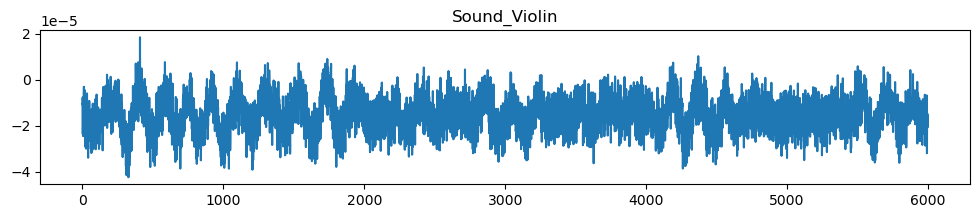

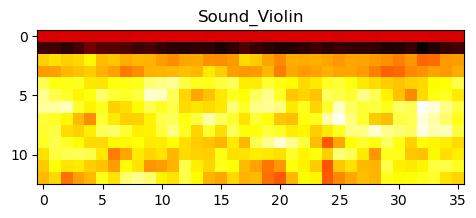

In [38]:
plt.figure(figsize=(12,2))
plt.plot(generated_audio_waves[30])
plt.title(generated_audio_labels[30])
plt.show()
plt.figure(figsize=(12, 2))
plt.imshow(mfcc_features[30].T, cmap='hot')
plt.title(generated_audio_labels[30])
plt.show()

In [41]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(generated_audio_labels)
print(label_encoded)

[2 0 0 ... 0 2 2]


In [42]:
label_encoded = label_encoded[:, np.newaxis]
label_encoded

array([[2],
       [0],
       [0],
       ...,
       [0],
       [2],
       [2]])

In [43]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)
one_hot_encoded

/Users/sanjokdangol/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [59]:
print(f"One hot encoded shape: {one_hot_encoded.shape}")  # Check the shape to ensure it matches the number of classes

# Number of unique classes
num_classes = one_hot_encoded.shape[1]
print(f"Number of classes: {num_classes}")

# Verify unique classes
unique_classes = np.unique(label_encoded)
print(f"Unique classes: {unique_classes}")

One hot encoded shape: (6000, 3)
Number of classes: 3
Unique classes: [0 1 2]


In [55]:
X = mfcc_features
y = one_hot_encoded
X = (X-X.min())/(X.max()-X.min())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [45]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [58]:
input_shape

(36, 13, 1)

In [46]:
# Reshape X_train and X_test such that they are having the same shape as the input shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_test.shape)

(4800, 36, 13, 1)
(1200, 36, 13, 1)


In [60]:
# Constructing the neural network architecture
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax')) 

model.compile(loss='categorical_crossentropy', 
     optimizer='adam',
     metrics=['acc'])


In [61]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 36, 13, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 36, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 18, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3456)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       442,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 455,747 (1.74 MB)

 Trainable params: 455,747 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.5920 - loss: 0.8622 - val_acc: 0.7608 - val_loss: 0.5573
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.7425 - loss: 0.5922 - val_acc: 0.7767 - val_loss: 0.5535
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.7630 - loss: 0.5494 - val_acc: 0.8000 - val_loss: 0.5161
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.7756 - loss: 0.5165 - val_acc: 0.8083 - val_loss: 0.4896
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.7872 - loss: 0.5088 - val_acc: 0.8200 - val_loss: 0.4923
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8017 - loss: 0.4767 - val_acc: 0.8267 - val_loss: 0.4762
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8049 - loss: 0.4669 - val_acc: 0.8367 - val_loss: 0.4290
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8222 - loss: 0.4393 - val_acc: 0.8400 - val_loss: 0.4338
Epoch 9/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - ac

loss: 0.2787538766860962
val_loss: 0.30035701394081116


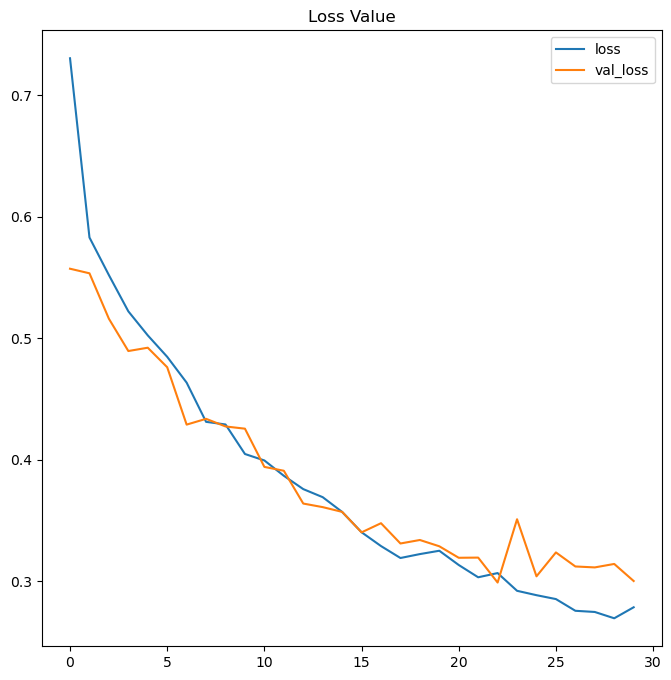

acc: 0.8943750262260437
val_acc: 0.8941666483879089


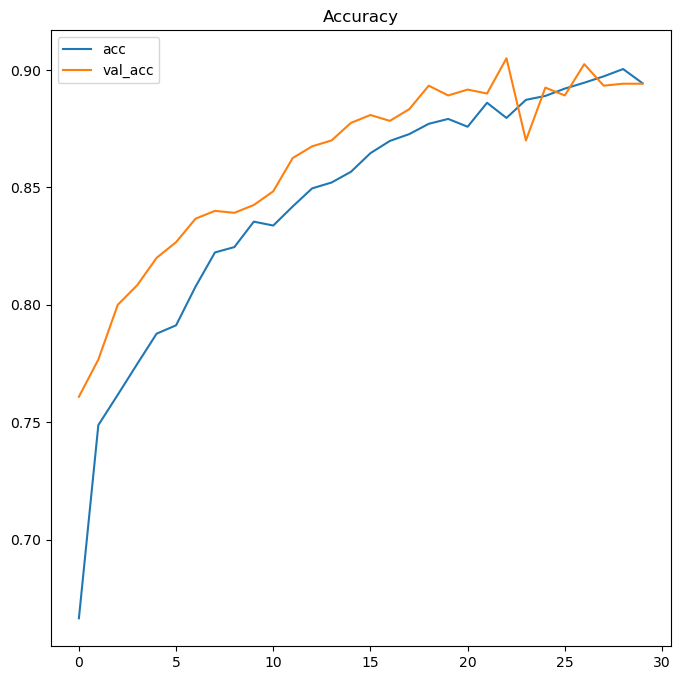

In [63]:
plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()
plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
print('acc:', history.history['acc'][-1])
print('val_acc:', history.history['val_acc'][-1])
plt.show()

# Model evaluation

In [64]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)
y_test = one_hot_encoder.inverse_transform(y_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


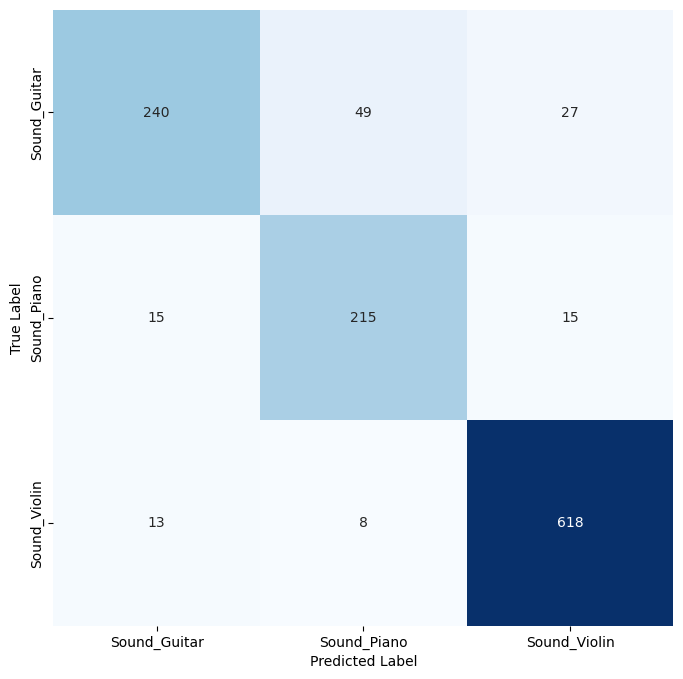

In [65]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()